<a href="https://colab.research.google.com/github/N00B-MA5TER/ML-Projects/blob/main/Sentiment_Analysis_on_Image_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the dataset and dependencies**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [17]:
import zipfile
import numpy as np

Emotion categories: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


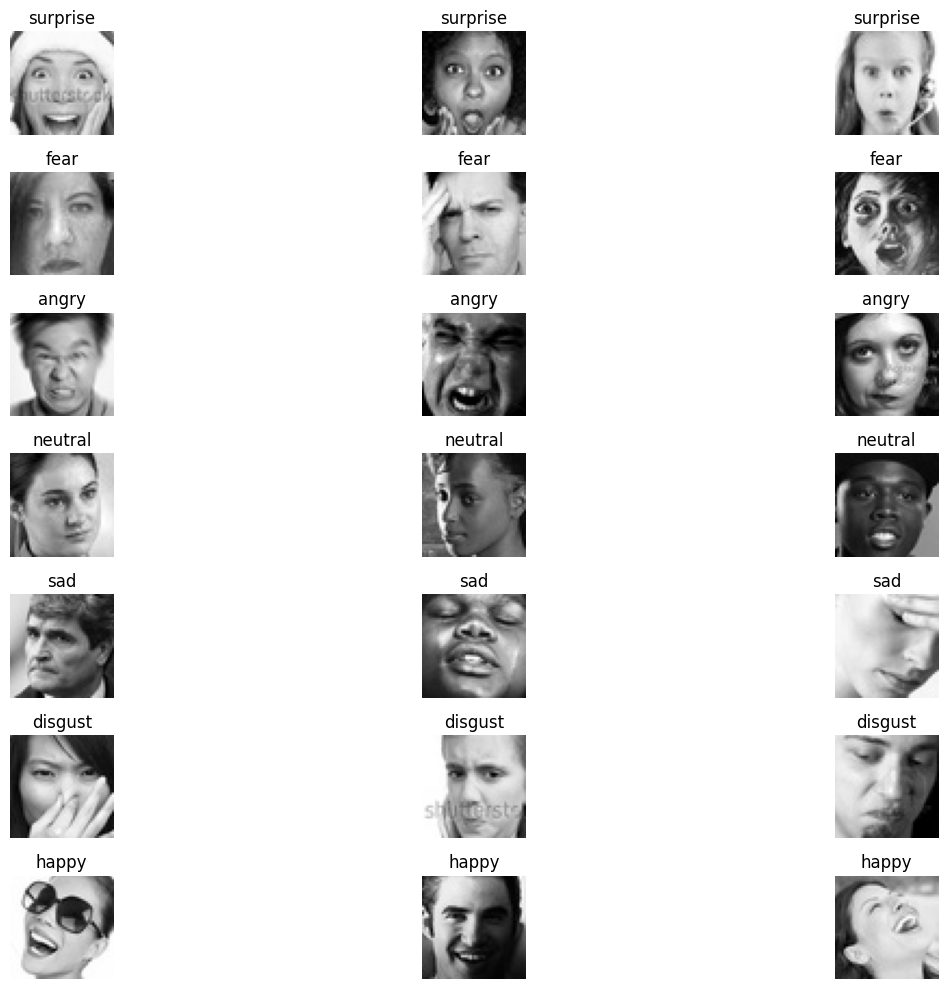

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

train_path = '/kaggle/input/fer2013/train'
test_path = '/kaggle/input/fer2013/test'

# Determine the structure and emotion categories
emotions = os.listdir(train_path)
print("Emotion categories:", emotions)

# Display sample images
num_samples_per_emotion = 3
plt.figure(figsize=(15, 10))

for i, emotion in enumerate(emotions):
    emotion_path = os.path.join(train_path, emotion)
    image_files = [f for f in os.listdir(emotion_path) if f.endswith('.jpg')]
    sample_images = np.random.choice(image_files, min(len(image_files), num_samples_per_emotion), replace=False)

    for j, img_file in enumerate(sample_images):
        img_path = os.path.join(emotion_path, img_file)
        img = Image.open(img_path)

        plt.subplot(len(emotions), num_samples_per_emotion, i * num_samples_per_emotion + j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(emotion)
        plt.axis('off')

plt.tight_layout()
plt.show()

**Data Preprocessing**

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Define image dimensions and batch size
img_width, img_height = 48, 48
batch_size = 32

# Create ImageDataGenerator for data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # Using 20% of the training data for validation

# Create a separate ImageDataGenerator for the validation set, only including rescaling
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create a separate ImageDataGenerator for the test set, only including rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory to load images for training
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Use flow_from_directory to load images for validation
validation_generator = validation_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

# Use flow_from_directory to load images for testing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

print("Data generators created.")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Data generators created.


**Building the CNN model**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the number of classes
num_classes = len(emotions)

# Build the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

**Training the model**

In [7]:
import tensorflow as tf

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the number of epochs
epochs = 15  # You can adjust this number

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

print("Model compiled and trained successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 254s 351ms/step - accuracy: 0.2518 - loss: 1.7948 - val_accuracy: 0.3980 - val_loss: 1.5915
Epoch 2/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 1:13 102ms/step - accuracy: 0.4062 - loss: 1.6403

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


717/717 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4062 - loss: 1.6403 - val_accuracy: 0.3942 - val_loss: 1.5912
Epoch 3/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 111s 154ms/step - accuracy: 0.3945 - loss: 1.5699 - val_accuracy: 0.4447 - val_loss: 1.4362
Epoch 4/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4062 - loss: 1.3512 - val_accuracy: 0.4485 - val_loss: 1.4309
Epoch 5/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 111s 155ms/step - accuracy: 0.4497 - loss: 1.4256 - val_accuracy: 0.4867 - val_loss: 1.3569
Epoch 6/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5000 - loss: 1.5029 - val_accuracy: 0.4813 - val_loss: 1.3603
Epoch 7/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 109s 152ms/step - accuracy: 0.4851 - loss: 1.3493 - val_accuracy: 0.5049 - val_loss: 1.3015
Epoch 8/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4375 - loss: 1.7338 - val_accuracy: 0.5080 - val_loss: 1.2931
Epoch 9/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 131s 151ms/step - accuracy: 0.5098 - loss: 1.2880 - val

**Model Evaluation**

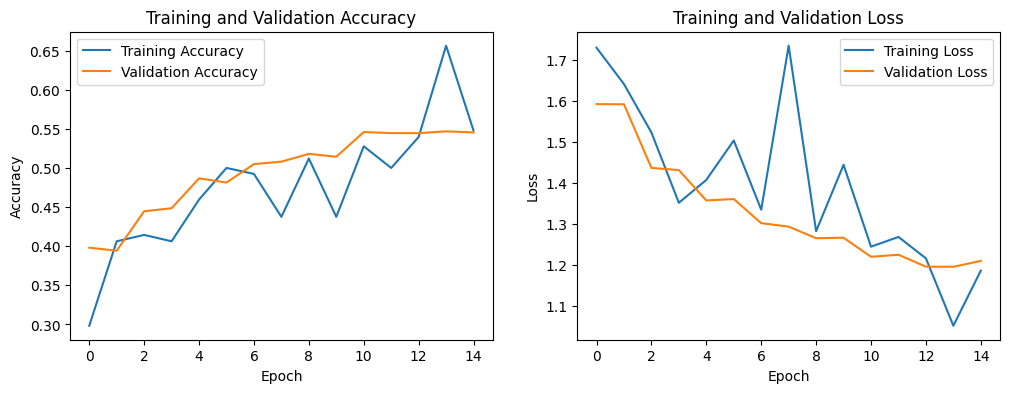

In [14]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


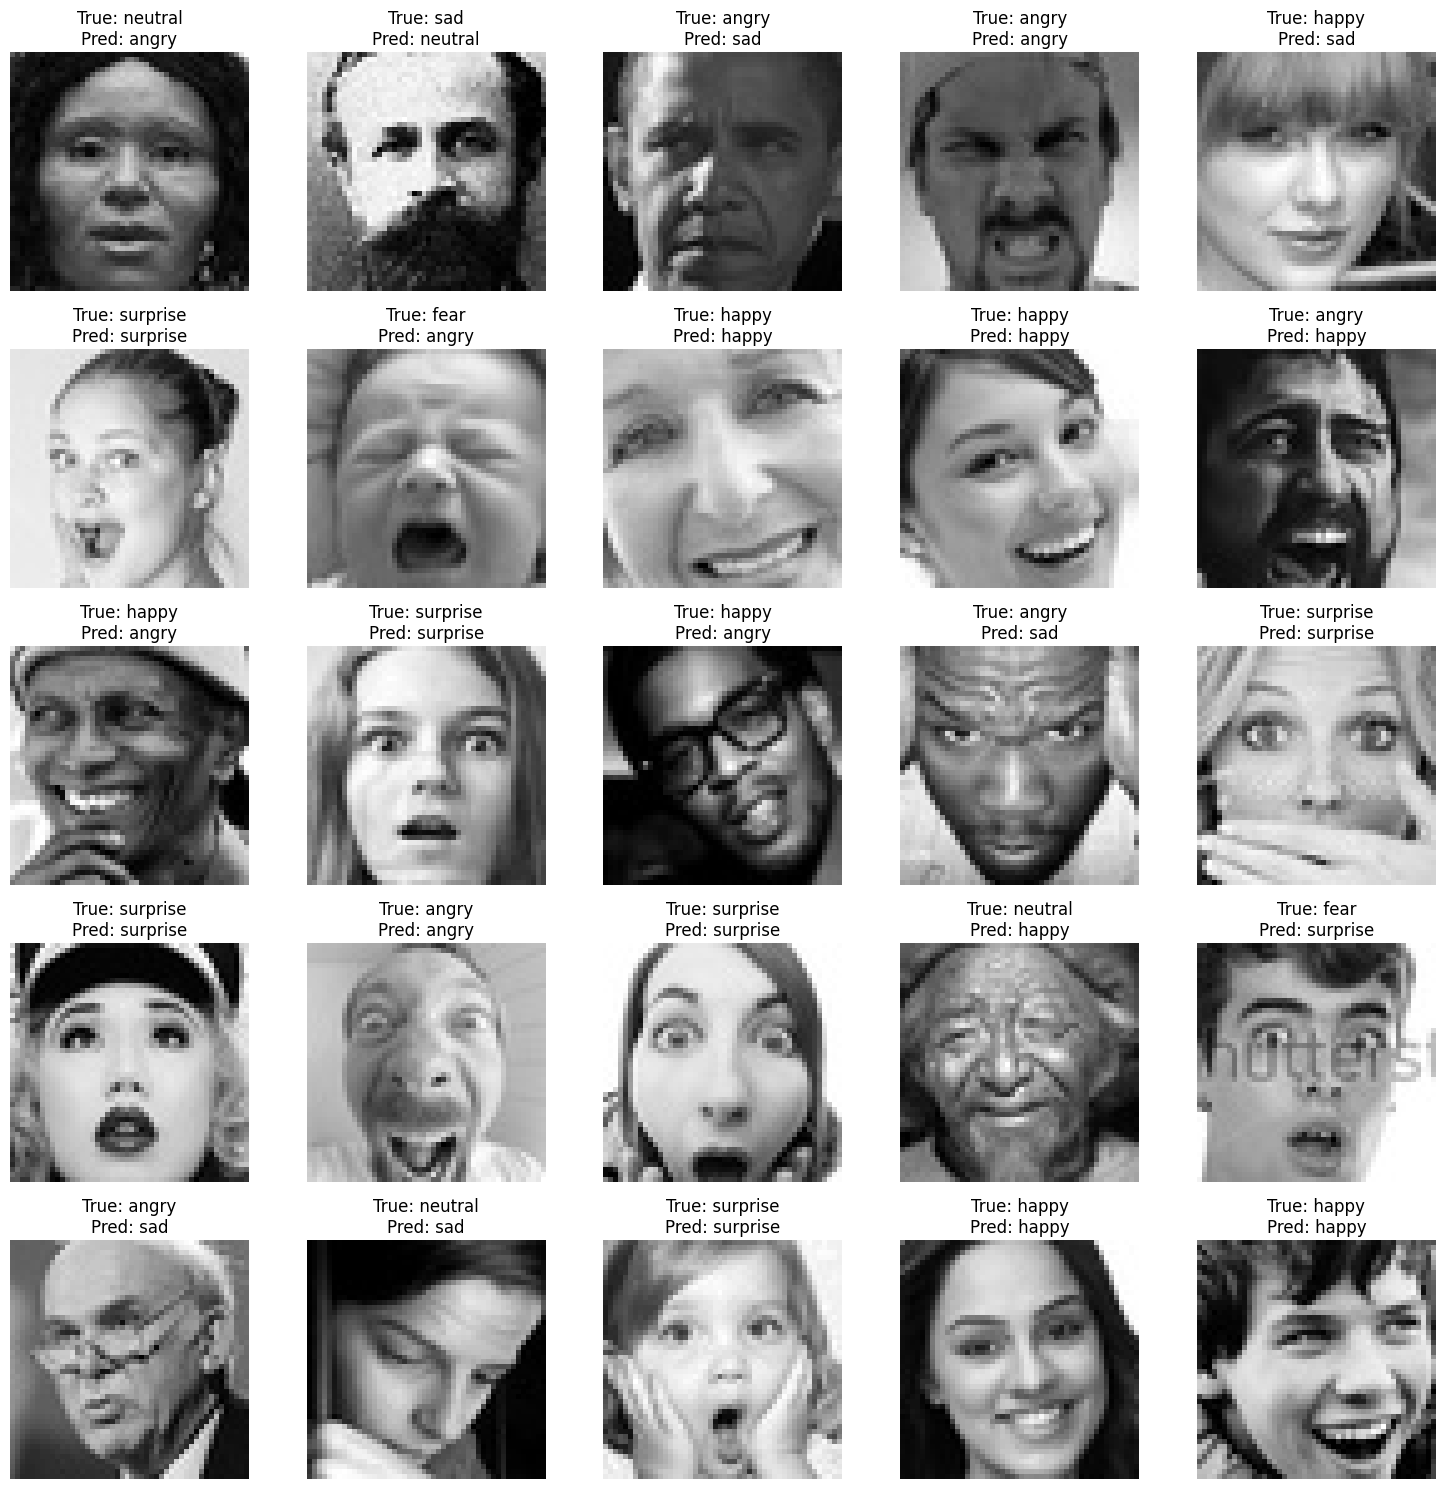

In [15]:
# Get a batch of test images and labels
test_images, test_labels = next(test_generator)

# Make predictions
predictions = model.predict(test_images)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Display sample images with predictions
plt.figure(figsize=(15, 15))
for i in range(min(len(test_images), 25)): # Display up to 25 images
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i].reshape(img_width, img_height), cmap='gray')
    plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step


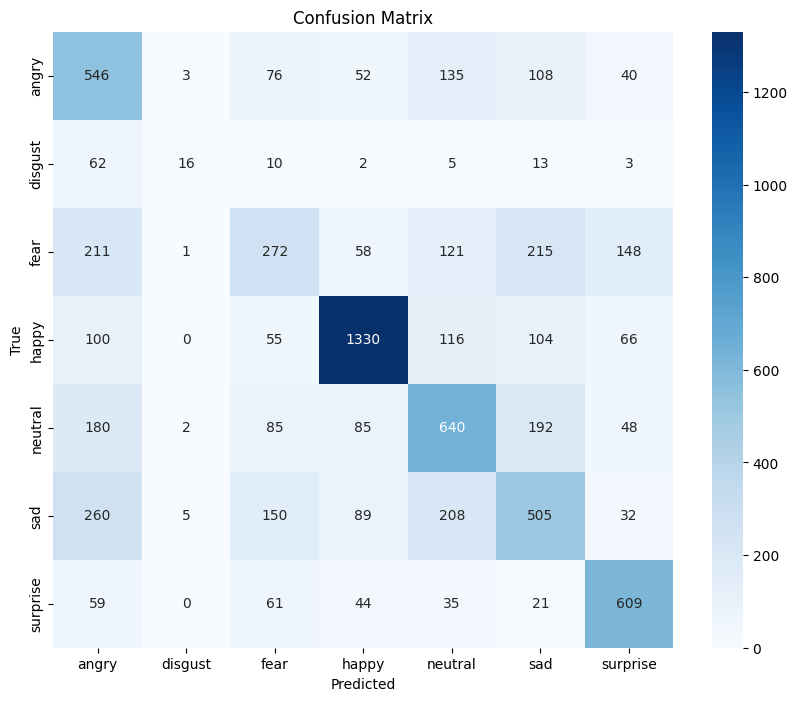

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get all test images and labels
test_images_all, test_labels_all = [], []
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    test_images_all.append(images)
    test_labels_all.append(labels)

test_images_all = np.concatenate(test_images_all)
test_labels_all = np.concatenate(test_labels_all)

# Make predictions on the entire test set
predictions_all = model.predict(test_images_all)

# Get the predicted and true class indices
predicted_classes_all = np.argmax(predictions_all, axis=1)
true_classes_all = np.argmax(test_labels_all, axis=1)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(true_classes_all, predicted_classes_all)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()